In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [159]:
d = 'csv_data/'
labor_force = pd.read_csv(d + 'civilian_labor_force.csv')
labor_force['DATE'] = pd.to_datetime(labor_force['DATE'])

total_employees = pd.read_csv(d+ 'midland_employee_total_count.csv')
df1 = total_employees.set_index(['Year']).stack().reset_index()
df1 = df1[df1.level_1 != 'Annual']
date = df1['Year'].astype(str) + ' '+ df1['level_1']
df1['Date'] = pd.to_datetime(date)
df1['Employment'] = df1[[0]]
total_employees = df1.drop(columns=['Year', 'level_1', 0])

mining_employment =  pd.read_csv(d + 'midland_mining_employment_thousands_of_people_per_year.csv')
df2 = mining_employment.set_index(['Year']).stack().reset_index()
df2 = df2[df2.level_1 != 'Annual']
date = df2['Year'].astype(str) + ' '+ df2['level_1']
df2['Date'] = pd.to_datetime(date)
df2['MineEmploy'] = df2[[0]]
df2['MineEmploy'] *= 1000
mining_employment = df2.drop(columns=['Year', 'level_1', 0])

unemployment_rate = pd.read_csv(d +'unemployment_rate_midland_tx_by_year.csv')
df3 = unemployment_rate.set_index(['Year']).stack().reset_index()
df3 = df3[df3.level_1 != 'Annual']
date = df3['Year'].astype(str) + ' '+ df3['level_1']
df3['Date'] = pd.to_datetime(date)
df3.replace('x', '0', inplace=True)
# df[50] = (unemployment_rate.loc[45:49].mean() + unemployment_rate.loc[51:55].mean()) / 2
df3.replace('   ', '3.71', inplace=True)
df3['Rate'] = df3[[0]]
df3['Rate'] = df3.Rate.astype(float)
df3['Rate'] /= 100
unemployment_rate = df3.drop(columns=['Year', 'level_1', 0])

oil_price = pd.read_csv(d + 'WTI_Oil.csv')
oil_price['Date'] = pd.to_datetime(oil_price['Date'])

In [160]:
total_employees

,Date,Employment
0,2008-01-01,66749.0
1,2008-02-01,67317.0
2,2008-03-01,67942.0
3,2008-04-01,68270.0
4,2008-05-01,68911.0
...,...,...
134,2018-05-01,102965.0
135,2018-06-01,104164.0
136,2018-07-01,104914.0
137,2018-08-01,105658.0


In [161]:
mining_employment

,Date,MineEmploy
0,2009-01-01,16800.0
1,2009-02-01,16200.0
2,2009-03-01,15700.0
3,2009-04-01,15100.0
4,2009-05-01,14700.0
...,...,...
118,2018-11-01,39000.0
119,2018-12-01,39400.0
120,2019-01-01,38900.0
121,2019-02-01,37300.0


In [162]:
unemployment_rate

,Date,Rate
0,2009-01-01,0.000
1,2009-02-01,0.040
2,2009-03-01,0.044
3,2009-04-01,0.045
4,2009-05-01,0.057
...,...,...
118,2018-11-01,0.019
119,2018-12-01,0.019
120,2019-01-01,0.023
121,2019-02-01,0.022


In [193]:
mp = oil_price.merge(unemployment_rate, on='Date').merge(mining_employment, on='Date').merge(total_employees, on='Date').merge(labor_force, left_on='Date', right_on='DATE').sort_values('Date')

In [283]:
img = 'images/'

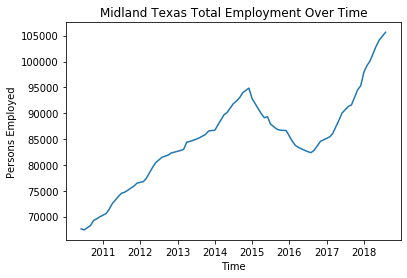

In [287]:
plt.plot(mp.Date, mp.Employment)
plt.title('Midland Texas Total Employment Over Time')
plt.xlabel('Time')
plt.ylabel('Persons Employed');
plt.savefig(img + 'employment_over_time.png')

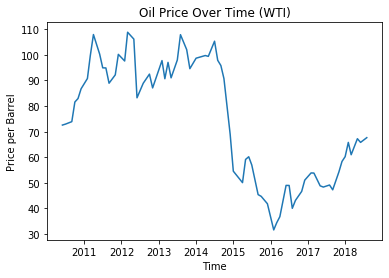

In [288]:
plt.plot(mp.Date, mp.Price)
plt.title('Oil Price Over Time (WTI)')
plt.xlabel('Time')
plt.ylabel('Price per Barrel');
plt.savefig(img + 'oil_price_over_time.png');

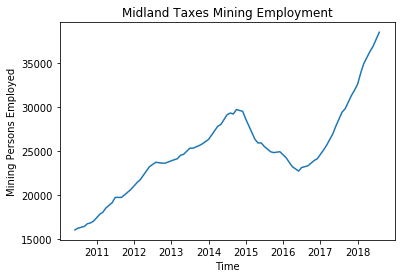

In [289]:
plt.plot(mp.Date, mp.MineEmploy)
plt.title('Midland Taxes Mining Employment')
plt.xlabel('Time')
plt.ylabel('Mining Persons Employed');
plt.savefig(img + 'mining_employment_over_time.png');

In [292]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Unemployment', color=color)
ax1.plot(mp.Date,  mp.Rate, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Oil Price', color=color)  # we already handled the x-label with ax1
ax2.plot(mp.Date, mp.Price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# breakeven point of oil
plt.hlines(48, min(mp.Date), max(mp.Date))
plt.text(48, 0.5, ' somelabel1', ha='left', va='center')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


ValueError: Image size of 75253x306 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 2 Axes>

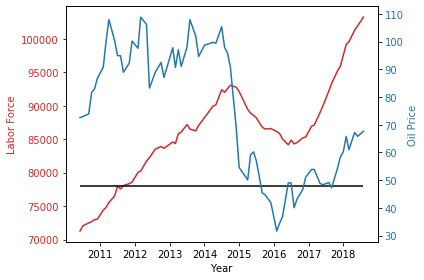

In [195]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Labor Force', color=color)
ax1.plot(mp.Date,  mp.TXMIDL9LFN, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Oil Price', color=color)  # we already handled the x-label with ax1
ax2.plot(mp.Date, mp.Price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# breakeven point of oil
plt.hlines(48, min(mp.Date), max(mp.Date))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [276]:
cr = mp[mp.Date > '2014-06-01']
pc = mp[mp.Date < '2014-06-01']
c = mp.query("Date < '2016-09-01' and Date > '2014-09-01'")

In [277]:
price_dt = cr.Price.shift(1) - cr.Price
employ_dt = cr.Employment.shift(1) - cr.Employment
mine_dt = cr.MineEmploy.shift(1) - cr.MineEmploy

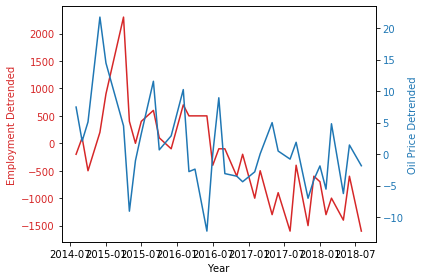

In [278]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Employment Detrended', color=color)
ax1.plot(cr.Date,  mine_dt, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Oil Price Detrended', color=color)  # we already handled the x-label with ax1
ax2.plot(cr.Date, price_dt, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

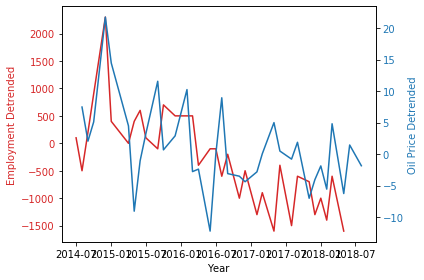

In [279]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Employment Detrended', color=color)
ax1.plot(cr.Date, mine_dt.shift(-2), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Oil Price Detrended', color=color)  # we already handled the x-label with ax1
ax2.plot(cr.Date, price_dt, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.savefig('books_read.png')

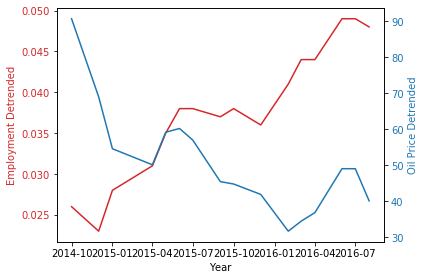

In [280]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Employment Detrended', color=color)
ax1.plot(c.Date, c.Rate, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Oil Price Detrended', color=color)  # we already handled the x-label with ax1
ax2.plot(c.Date, c.Price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [282]:
np.corrcoef(c.Rate, c.Price)

array([[ 1.        , -0.66757067],
       [-0.66757067,  1.        ]])